# Rao-blackwellized particle filter for Kalman filter


References
* [inference_test.py](https://github.com/probml/dynamax/blob/main/dynamax/slds/inference_test.py) in probml/dynamax
* Section 13.4.2 in PML Book 2
* Murphy, Kevin, and Stuart Russell. "Rao-Blackwellised particle filtering for dynamic Bayesian networks." Sequential Monte Carlo methods in practice. New York, NY: Springer New York, 2001. 499-515.

In [1]:
import ssm

In [2]:
import jax
import chex
import einops
import distrax
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [3]:
%config InlineBackend.figure_format = "retina"

sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (7.2, 3.0)

jnp.set_printoptions(linewidth=200)

In [4]:
plt.rcParams["text.usetex"] = True

In [717]:
key = jax.random.PRNGKey(314)
key_sample, key_train = jax.random.split(key)
key_init, key_eval = jax.random.split(key_train)

In [718]:
ma_n = 10
R = jnp.eye(1) * 0.5
H_ma = jnp.ones(10) * 1.
H, F, T = ssm.init_ma_components(H_ma=H_ma)

In [719]:
n_steps = 500
steps = jnp.arange(n_steps)

sample = ssm.sample_ssm(key_sample, F, H, T, R, n_steps // 2)
sample2 = ssm.sample_ssm(key_sample, F, H, T, 3 * R, n_steps // 2)

sample = jax.tree.map(lambda x, y: jnp.concat([x, y], axis=0), sample, sample2)

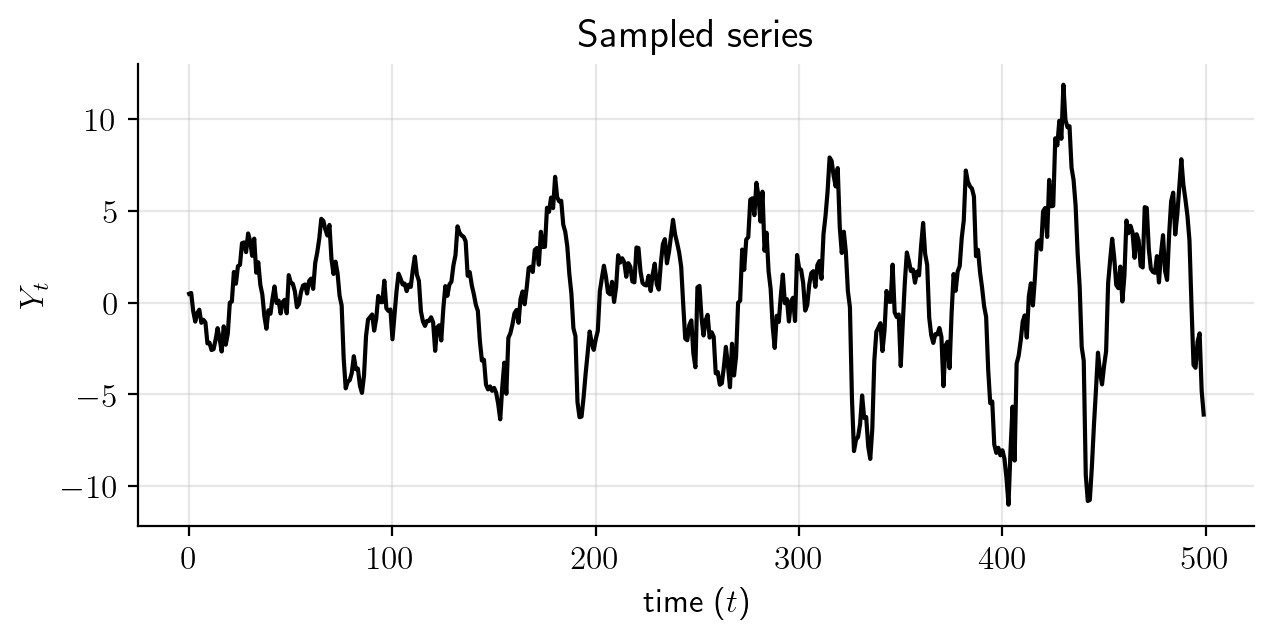

In [720]:
plt.plot(sample["y"], c="black", markersize=3)
plt.xlabel("time ($t$)")
plt.title("Sampled series")
plt.ylabel("$Y_t$")
plt.grid(alpha=0.3)

In [721]:
y = sample["y"][:, None]

## The Kalman filter (with unknown R)

In [732]:
@chex.dataclass
class KFConfig:
    H: jax.Array
    F: jax.Array
    sigma_rho: float


@chex.dataclass
class KFState:
    mean: jax.Array
    cov: jax.Array
    rho: float
    log_weight: float

    @staticmethod
    def init(key, mean, cov, n_particles, cov_rho):
        means = einops.repeat(mean, "m -> s m", s=n_particles)
        covs = einops.repeat(cov, "i j -> s i j", s=n_particles)
        rhos = jax.random.normal(key, (n_particles,)) * jnp.sqrt(cov_rho)
        log_weights = jnp.repeat(-jnp.log(n_particles), n_particles)
        
        return KFState(
            mean=means, 
            cov=covs,
            rho=rhos,
            log_weight=log_weights
        )


def kf_step(y, bel, cfg):
    """
    Update belief and compute log-posterior-predictive
    """
    R = jnp.eye(1) * jnp.exp(bel.rho)
    Q = T @ R @ T.T
    
    # Predict step
    mean_pred = cfg.F @ bel.mean# + B
    cov_pred = cfg.F @ bel.cov @ cfg.F.T + Q

    # Innovation, variance, and Kalman gain
    yhat = cfg.H @ mean_pred
    err = y - yhat
    St = cfg.H @ cov_pred @ cfg.H.T + R
    Kt = jnp.linalg.solve(St, cfg.H @ cov_pred).T

    # Update step
    Kcov = jnp.eye(len(bel.mean)) - Kt @ cfg.H
    mean_update = mean_pred + Kt @ err
    cov_update = Kcov @ cov_pred @ Kcov.T + Kt @ R @ Kt.T

    bel = bel.replace(
        mean=mean_update,
        cov=cov_update
    )

    log_pp = distrax.MultivariateNormalFullCovariance(yhat, St).log_prob(y)

    return bel, log_pp


vkf_step_all = jax.vmap(kf_step, in_axes=(None, 0, 0, None))
vkf_step_B = jax.vmap(kf_step, in_axes=(None, 0, None, None))

# RBPF with transition as proposal

In [733]:
def stratified_resampling(key, log_weights, n_particles):
    """
    TODO: any way to work with log_weight only?
    """
    S = log_weights.shape[0]
    weights = jnp.exp(log_weights)
    cdf = jnp.cumsum(weights)
    # Generate n_particles stratified uniform samples in [0, 1)
    u = (jnp.arange(n_particles) + jax.random.uniform(key, shape=(n_particles,))) / n_particles
    indices = jnp.searchsorted(cdf, u)
    return indices

In [758]:
@partial(jax.vmap, in_axes=(0, None, 0, None))
def kf_rbpf_step(key, y, bel, cfg):
    """
    Draw a single sample from proposal p(psi(t) | psi(t,s)),
    update belief and compute log_posterior_predictive
    """
    rho_new = jax.random.normal(key) * cfg.sigma_rho + bel.rho
    bel = bel.replace(rho=rho_new)
    bel_update, log_pp = kf_step(y, bel, cfg)

    return bel_update, log_pp


def _resample(key, log_weights, bel):
    """
    Resample particles if the effective sample size (ESS)
    is below some threshold
    """
    indices = jax.random.categorical(key, log_weights, shape=(n_particles,))
    # indices = stratified_resampling(key, log_weights, n_particles)
    bel = jax.tree.map(lambda x: x[indices], bel)

    # Reset particles
    bel = bel.replace(
        log_weight=jnp.full(n_particles, -jnp.log(n_particles))
    )
    
    return bel


def _continue(key, log_weights, bel):
    bel = bel.replace(
        log_weight=log_weights
    )
    return bel


def step(bel, xs, cfg):
    y, key = xs
    key_propagate, key_resample = jax.random.split(key)
    keys = jax.random.split(key_propagate, n_particles)
    bel_update, log_pp = kf_rbpf_step(keys, y, bel, cfg)

    log_weights = bel.log_weight + log_pp
    log_weights = log_weights - jax.nn.logsumexp(log_weights)
    ess = 1 / jnp.sum(jnp.exp(log_weights) ** 2)

    bel_update = jax.lax.cond(
        ess < n_particles * 0.2,
        _resample,
        _continue,
        key_resample, log_weights, bel_update
    )

    return bel_update, (log_weights, bel_update.rho, bel_update.mean)

### Filter

In [766]:
n_particles = 300
config = KFConfig(
    H=H[None],
    F=F,
    sigma_rho=0.05
    
)


cov_rho_init = 0.1

In [767]:
mean_init = jnp.zeros(ma_n)
cov_init = jnp.eye(ma_n) * 1
keys = jax.random.split(key_eval, n_steps)
bel_init = KFState.init(key_train, mean_init, cov_init, n_particles, cov_rho_init)

Xs = (y, keys)
_step = partial(step, cfg=config)
bel_final, (hist_ll, hist_rho, hist_mean) = jax.lax.scan(_step, bel_init, Xs)

In [768]:
log_weight = hist_ll - jax.nn.logsumexp(hist_ll, axis=1, keepdims=True)
weights = jnp.exp(log_weight)

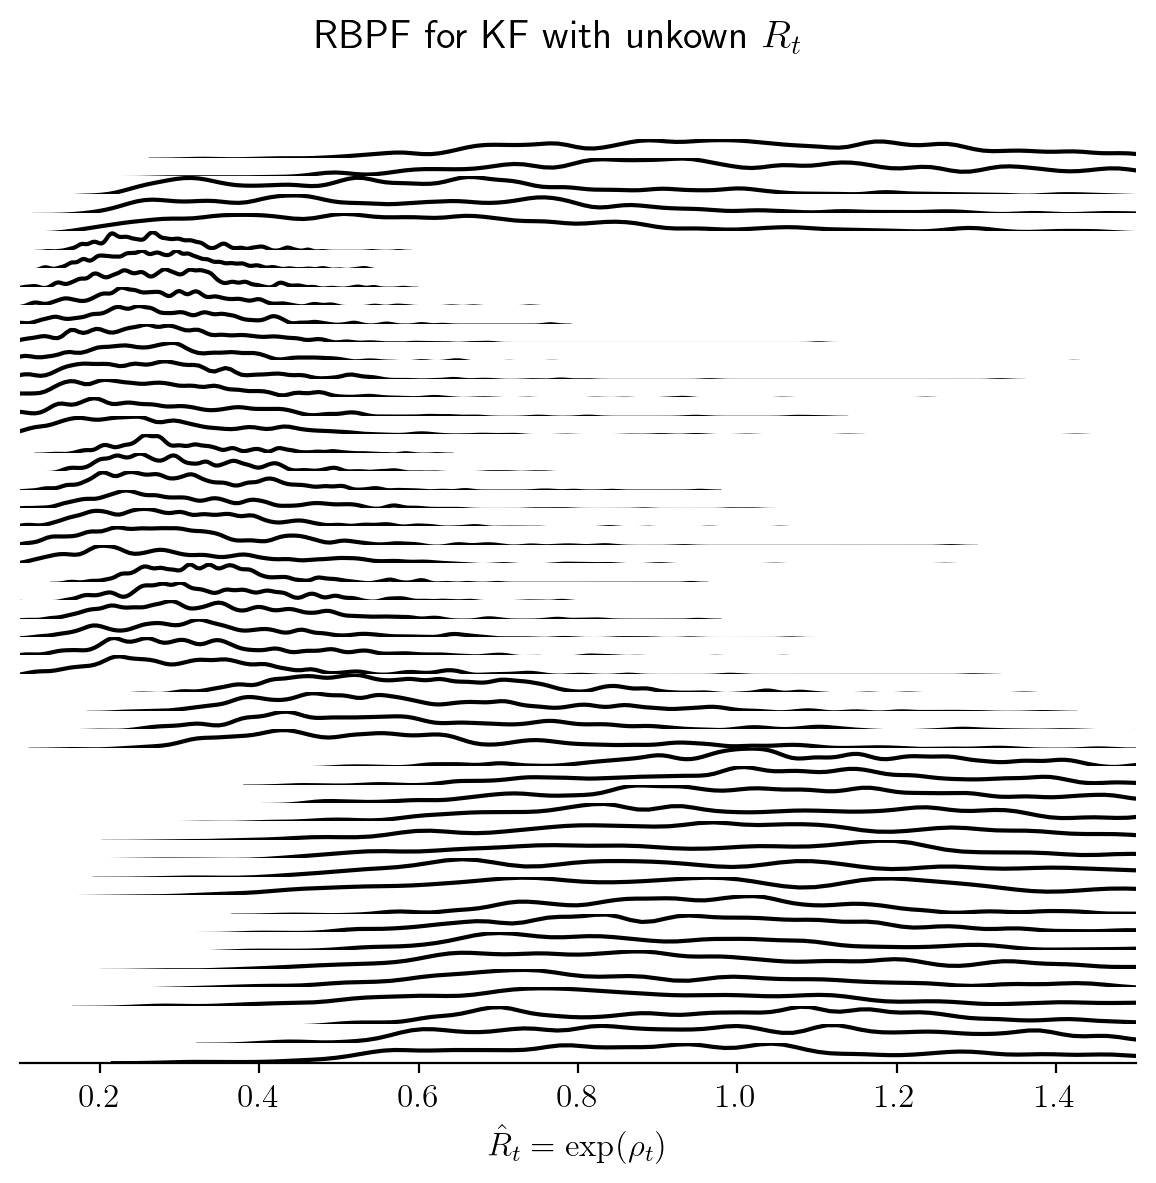

In [769]:
tvals = [1, 2, 5, 10, 15, 20, 25]
tvals = jnp.arange(1, 500, 10)
fig, axs = plt.subplots(len(tvals), 1, sharex=True, sharey=False, figsize=(7.2, 6.0))

for t, ax in zip(tvals, axs):
    sns.kdeplot(jnp.exp(hist_rho[t]), ax=ax, c="black", bw_adjust=0.2)
    ax.set_ylabel("")
    # ax.set_yscale('log')
    ax.set_yticks([])
    # ax.axis("off")
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlim(left=0.1, right=1.5)
ax.spines["bottom"].set_visible(True)
ax.set_xlabel(r"$\hat{R}_t = \exp(\rho_t)$")
plt.suptitle("RBPF for KF with unkown $R_t$")
plt.subplots_adjust(hspace=-0.1)

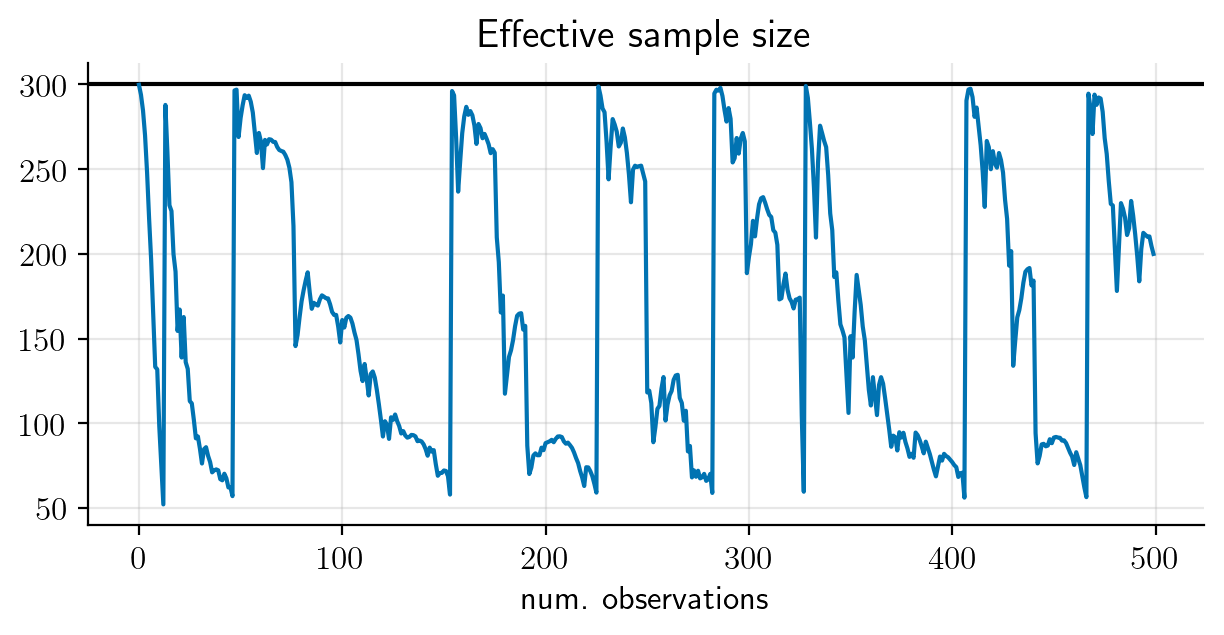

In [770]:
# Effective sample size
plt.title("Effective sample size")
plt.axhline(y=n_particles, c="black")
ess = 1 / jnp.sum(weights ** 2, axis=1)
plt.plot(ess)
plt.xlabel("num. observations")
plt.grid(alpha=0.3)

In [771]:
mean = (jnp.exp(hist_rho) * weights).sum(axis=-1) / weights.sum(axis=-1)
var = (jnp.exp(hist_rho) ** 2 * weights).sum(axis=-1) - (jnp.exp(hist_rho) * weights).sum(axis=-1) ** 2

Text(0.5, 0, 'num. observations')

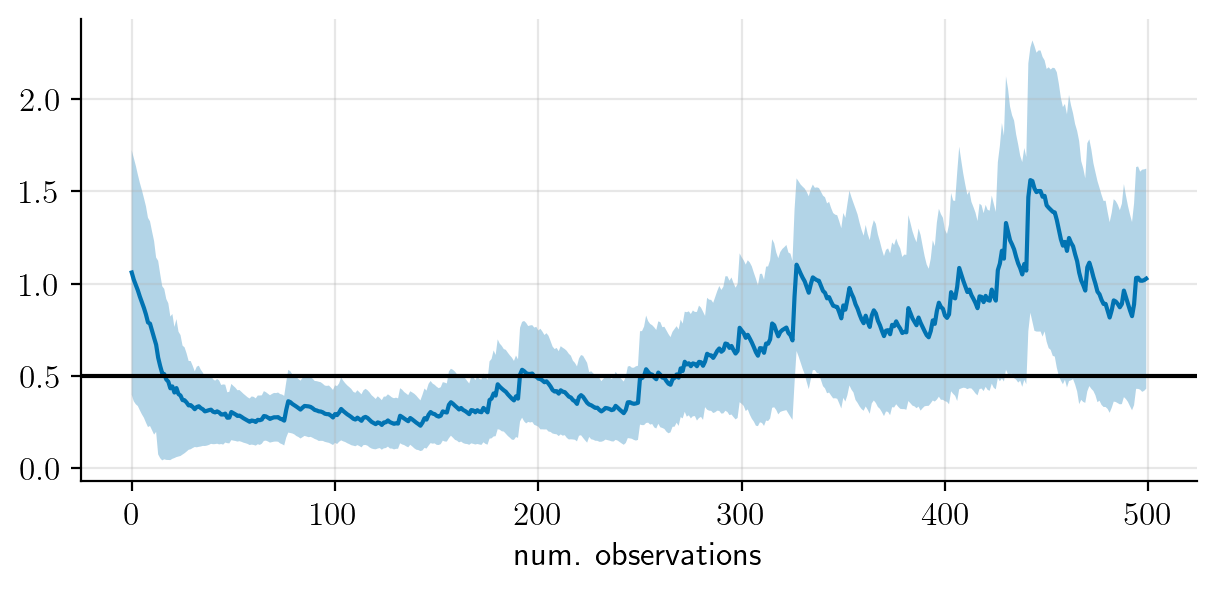

In [772]:
plt.fill_between(steps, mean - 2 * jnp.sqrt(var), mean + 2 * jnp.sqrt(var), alpha=0.3)
plt.plot(mean)
plt.grid(alpha=0.3)
# plt.title(r"$\mathbb{E}$")
plt.axhline(y=R, c="black")
plt.xlabel("num. observations")